In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import tensorflow as tf
from keras import models
from keras import layers
from keras.layers import Dropout
from tensorflow import keras
from sklearn.model_selection import train_test_split
import warnings
import random
warnings.filterwarnings('ignore')

from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
os.makedirs("./models/final_model",exist_ok=True)


DATASET_PATH = "./flatten/"
# for문으로 처리하려고 했으나 각 진단마다 에폭이나 learning rate를 바꿔야 하는일들이 있어서 4개 타입 바꿔가면서 4번 돌릴것.
CLASS_NAME="normal_abnormal" #MCI_AD, SCI_AD, SCI_MCI,normal_abnormal
BASE_SAVE_PATH = f"./models/final_model/{CLASS_NAME}/"

BATCH_SIZE = 16

# 10번 이하는 쏠림이 있는 모델이 생성되는 경우가 많음. 
EPOCHS = 1
# 학습이 안되는경우 learning rate를 조정하시는게 가장 효과적인 방법입니다.

LEARNING_RATE = 1.0e-6
SEED = 14



In [3]:
# seed를 고정. 일정한 값 도출 및 추가되는 다른 것들에 대한 효과를 보기위해서 고정한다.
# 랜덤시드 제대로 고정됐는지 실험 완료
# 재현성을 위해 시드를 고정하지만 아래 3개 환경은 성능이 떨어지는 이슈가 있어서 고정했음
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    # os.environ['TF_DETERMINISTIC_OPS'] = "1"
    # os.environ['TF_CUDNN_DETERMINISM'] = "1"
    # os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(SEED)

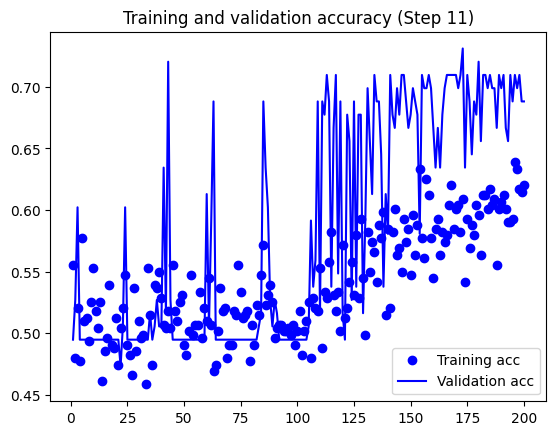

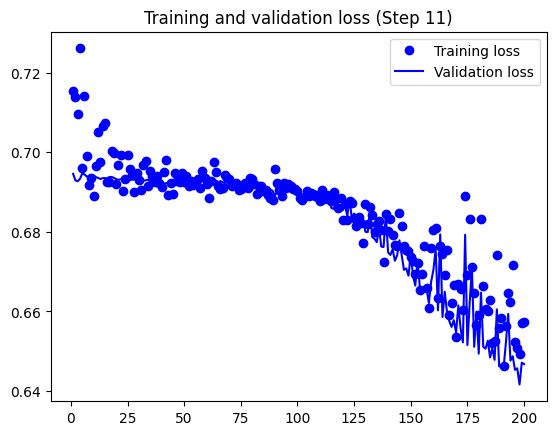

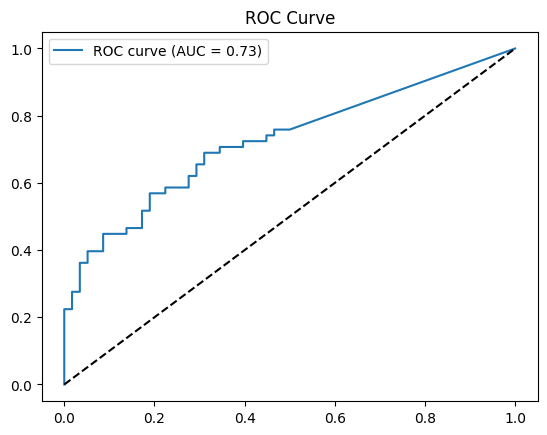

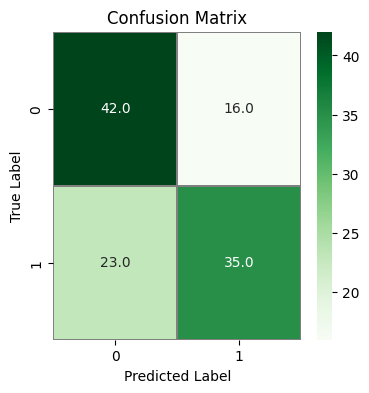

Accuracy: 0.66, Precision: 0.69, Recall: 0.60, Specificity: 0.72, F1: 0.64, AUC: 0.73


In [8]:

# 경로 및 기본 설정
base_path = f"./flatten/{CLASS_NAME}/"
all_score = []
all_columns = []

def concatenate_data(dataframes, order, save_path=None, filename=None):
    """
    주어진 순서에 따라 DataFrame을 결합하고, 필요시 저장
    - dataframes: 데이터프레임 리스트
    - order: 결합 순서 (리스트)
    - save_path: 저장할 경로 (옵션, 기본값 None)
    - filename: 저장할 파일 이름 (옵션, 기본값 None)
    """
    concatenated = dataframes[order[0]-1].iloc[:, :-3]  # 첫 번째 데이터프레임
    for idx in order[1:]:
        concatenated = pd.concat([concatenated, dataframes[idx-1].iloc[:, :-3]], axis=1)
    
    # 저장 조건 확인
    if save_path and filename:
        os.makedirs(save_path, exist_ok=True)  # 경로가 없으면 생성
        save_filepath = os.path.join(save_path, filename)
        concatenated.to_csv(save_filepath, index=False)
        print(f"결합된 데이터가 저장되었습니다: {save_filepath}")
    
    return concatenated

# 모델 생성 함수
def create_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 학습 및 평가 함수
def train_and_evaluate(model, x_train, y_train, x_valid, y_valid, x_test, y_test, idx):
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=200, verbose=0)
    #loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

    # 결과 시각화
    plot_history(history, idx)

    # 예측 및 성능 평가
    predictions = model.predict(x_test)
    pred_label = predictions.round()
    metrics_result = evaluate_metrics(y_test, predictions, pred_label)

    return metrics_result

# 학습 히스토리 시각화
def plot_history(history, idx):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
    plt.title(f'Training and validation accuracy (Step {idx})')
    plt.legend()
    plt.show()

    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title(f'Training and validation loss (Step {idx})')
    plt.legend()
    plt.show()

# 성능 평가 및 ROC 시각화
def evaluate_metrics(y_test,predict_proba, pred_label):
    cm = confusion_matrix(y_test, pred_label)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    precision = precision_score(y_test, pred_label)
    recall = recall_score(y_test, pred_label)
    specificity = tn / (tn + fp)
    f1 = 2 * (precision * recall) / (precision + recall)
    auc_score = roc_auc_score(y_test,predict_proba)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, predict_proba)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    # confusion metrics
    f,ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, Specificity: {specificity:.2f}, F1: {f1:.2f}, AUC: {auc_score:.2f}")
    return [accuracy, precision, recall, specificity, f1, auc_score]

# 데이터 로드
def load_files(base_path, step_num, prefix):
    files = sorted([file for file in os.listdir(base_path) if prefix + str(step_num) in file], 
                   key=lambda x: int(x.split("q")[1].split("_")[0]))
    dataframes = [pd.read_csv(os.path.join(base_path, file)) for file in files]
    return dataframes

# 메인 실행
for step_num in range(4, 5):
    train_dfs = load_files(base_path, step_num, "train")
    test_dfs = load_files(base_path, step_num, "test")

    # 문제 결합 순서
    # 순서에 따라 성능이 달라지므로 모델 생성당시에 정확도가 높은 순서대로 나열시켰음.
    base_order = [8, 3, 1, 7, 5, 6, 11, 4, 10, 2, 9]
    problem_order = {i: base_order[:i] for i in range(1, len(base_order) + 1)}

    # 문항갯수별로 모델을 만들어야 하는경우가 있으므로 아래 range의 숫자를 변경.
    for idx in range(11, 12):  # 1부터 11문항까지 순회 문항 한개씩 결과보고 싶을경우 1부터 선언.
        #csv로 결합된거 저장하고 싶으면 concatenate_data에 경로 추가.
        x_train = concatenate_data(train_dfs, problem_order[idx])
        y_train = train_dfs[7].iloc[:, -1]
        x_test = concatenate_data(test_dfs, problem_order[idx])
        y_test = test_dfs[7].iloc[:, -1]

        # train/validation split
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

        model = create_model(x_train.shape[1])

        metrics_result = train_and_evaluate(model, x_train, y_train, x_valid, y_valid, x_test, y_test, idx)
        
        # model save 추론 모델 필요할 경우 저장.
        model.save(BASE_SAVE_PATH +"{}_fold{}_acc{}.h5".format(CLASS_NAME,step_num, round(metrics_result[0]*100)))

        all_score.append(metrics_result)
        all_columns.append(f"Step {step_num}, Question {idx}")

# 결과 저장
result_df = pd.DataFrame(all_score, index=all_columns, columns=["accuracy", "precision", "recall", "specificity", "f1_score", "auc"])
result_df.to_csv("./result/evaluation_results.csv", index=False)


# 원본 코드
객체화를 하지 않아서 지져분하지만 이해가 쉽도록 최대한 단순하게 표현하였습니다.
위에 리펙토링한 코드가 있으니 참고

동적변수 global은 디버깅에 좋지 않아서 사용하지 않는게 좋습니다.
문항의 순서가 변할경우 어떤결과가 나오게 되는지 확인하기 위해서 변수 한개씩 생성했습니다. 

이 데이터는 최종진단 테스트로 테스트와 train만 있는 데이터를 사용해서 학습하였습니다.


In [4]:
#chart option
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    #plt.savefig(base_path+"image/"+base_path[17:26]+"_문항개수"+str(idx)+"개 "+'AUC'+'.png')
    plt.show()


img_features_50_q1_train4_normalvsabnormal.csv
img_features_50_q2_train4_normalvsabnormal.csv
img_features_50_q3_train4_normalvsabnormal.csv
img_features_50_q4_train4_normalvsabnormal.csv
img_features_50_q5_train4_normalvsabnormal.csv
img_features_50_q6_train4_normalvsabnormal.csv
img_features_50_q7_train4_normalvsabnormal.csv
img_features_50_q8_train4_normalvsabnormal.csv
img_features_46_q9_train4_normalvsabnormal.csv
img_features_50_q10_train4_normalvsabnormal.csv
img_features_50_q11_train4_normalvsabnormal.csv
img_features_50_q1_test4_normalvsabnormal.csv
img_features_50_q2_test4_normalvsabnormal.csv
img_features_50_q3_test4_normalvsabnormal.csv
img_features_50_q4_test4_normalvsabnormal.csv
img_features_50_q5_test4_normalvsabnormal.csv
img_features_50_q6_test4_normalvsabnormal.csv
img_features_50_q7_test4_normalvsabnormal.csv
img_features_50_q8_test4_normalvsabnormal.csv
img_features_46_q9_test4_normalvsabnormal.csv
img_features_50_q10_test4_normalvsabnormal.csv
img_features_50_q11_

2024-12-03 16:13:11.506254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-03 16:13:11.522659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-03 16:13:11.522818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-03 16:13:11.523733: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

4/4 [==============================] - 0s 1ms/step - loss: 0.6469 - accuracy: 0.6724


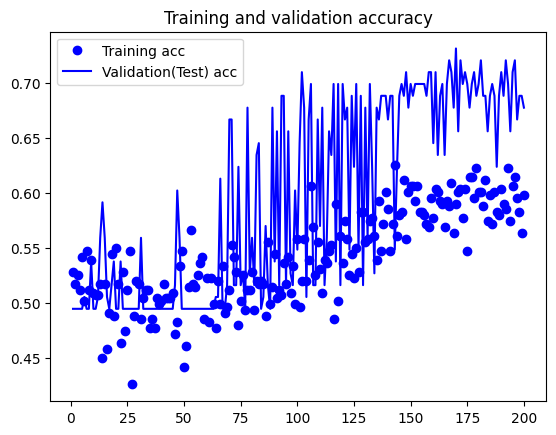

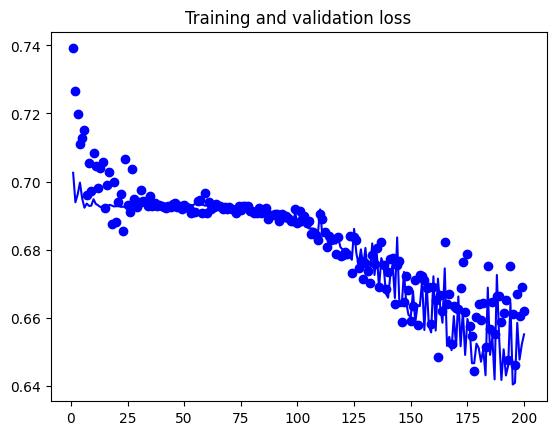

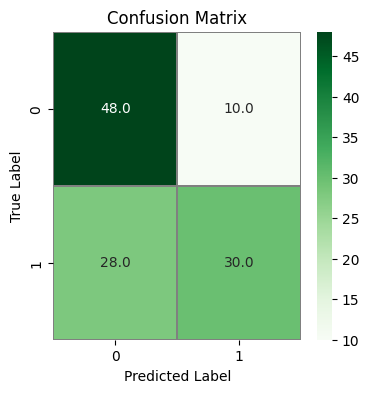

Precision  75.0
Recall  51.724137931034484
specificity  82.75862068965517
F1 Score  61.22448979591838
Accuracy score: 67.24137931034483
Log loss score: 0.6072731853045267
auc_score: 0.7517835909631391


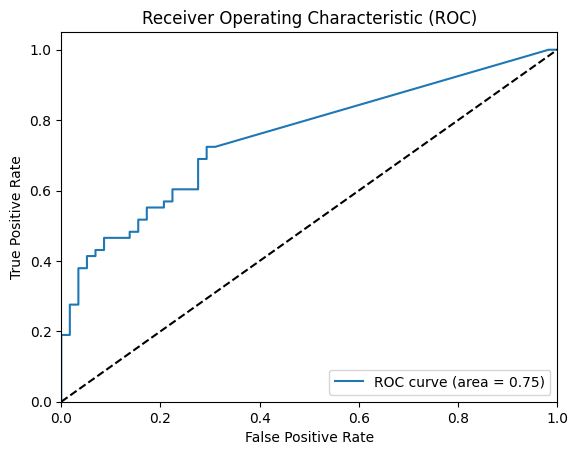

4학습 종료


In [10]:
base_path = f"./flatten/{CLASS_NAME}/"
save_path = "./flatten/append/"
all_score = []
all_columns=[]

for step_num in range(4,5):
    files = os.listdir(base_path)

    train_file_name=sorted(list(filter(lambda x: "train"+str(step_num) in x, files)), 
                           key=lambda x: int(x.split("q")[1].split("_")[0]))
    test_file_name=sorted(list(filter(lambda x: "test"+str(step_num) in x, files)), 
                          key=lambda x: int(x.split("q")[1].split("_")[0]))
    
    for ii, fold_no in enumerate(train_file_name):
        print(fold_no)
        globals()["train_{}".format(ii)]=pd.read_csv(base_path+fold_no)
    for i,fold_no in enumerate(test_file_name):
        print(fold_no)
        globals()["test_{}".format(i)]=pd.read_csv(base_path+fold_no)

    #각 파일마다 label이 달려있기 때문에 붙일때 라벨이 중복되는것을 방지하기 위해 -3을 붙임.

    train_all_1=train_7
    
    train_all_2=pd.concat([train_7.iloc[:,0:-3],train_2],axis=1)
    
    train_all_3=pd.concat([train_7.iloc[:,0:-3],train_2.iloc[:,0:-3],train_0],axis=1)
    
    train_all_4=pd.concat([train_7.iloc[:,0:-3],train_2.iloc[:,0:-3],train_0.iloc[:,0:-3],train_6],axis=1)
    
    train_all_5=pd.concat([train_7.iloc[:,0:-3],train_2.iloc[:,0:-3],train_0.iloc[:,0:-3],train_6.iloc[:,0:-3],train_4],axis=1)
    
    train_all_6=pd.concat([train_7.iloc[:,0:-3],train_2.iloc[:,0:-3],train_0.iloc[:,0:-3],train_6.iloc[:,0:-3],train_4.iloc[:,0:-3],train_5],axis=1)
    
    train_all_7=pd.concat([train_7.iloc[:,0:-3],train_2.iloc[:,0:-3],train_0.iloc[:,0:-3],train_6.iloc[:,0:-3],train_4.iloc[:,0:-3],train_5.iloc[:,0:-3],train_10],axis=1)
    
    train_all_8=pd.concat([train_7.iloc[:,0:-3],train_2.iloc[:,0:-3],train_0.iloc[:,0:-3],train_6.iloc[:,0:-3],train_4.iloc[:,0:-3],train_5.iloc[:,0:-3],train_10.iloc[:,0:-3],train_3],axis=1)
    
    train_all_9=pd.concat([train_7.iloc[:,0:-3],train_2.iloc[:,0:-3],train_0.iloc[:,0:-3],train_6.iloc[:,0:-3],train_4.iloc[:,0:-3],train_5.iloc[:,0:-3],train_10.iloc[:,0:-3],train_3.iloc[:,0:-3],train_9],axis=1)
    
    train_all_10=pd.concat([train_7.iloc[:,0:-3],train_2.iloc[:,0:-3],train_0.iloc[:,0:-3],train_6.iloc[:,0:-3],train_4.iloc[:,0:-3],train_5.iloc[:,0:-3],train_10.iloc[:,0:-3],train_3.iloc[:,0:-3],train_9.iloc[:,0:-3],train_1],axis=1)
    
    train_all_11=pd.concat([train_7.iloc[:,0:-3],train_2.iloc[:,0:-3],train_0.iloc[:,0:-3],train_6.iloc[:,0:-3],train_4.iloc[:,0:-3],train_5.iloc[:,0:-3],train_10.iloc[:,0:-3],train_3.iloc[:,0:-3],train_9.iloc[:,0:-3],train_1.iloc[:,0:-3],train_8], axis=1)

    test_all_1=test_7 
    
    test_all_2=pd.concat([test_7.iloc[:,0:-3],test_2], axis=1) 
    
    test_all_3=pd.concat([test_7.iloc[:,0:-3],test_2.iloc[:,0:-3],test_0], axis=1) 
    
    test_all_4=pd.concat([test_7.iloc[:,0:-3],test_2.iloc[:,0:-3],test_0.iloc[:,0:-3],test_6], axis=1)
    
    test_all_5=pd.concat([test_7.iloc[:,0:-3],test_2.iloc[:,0:-3],test_0.iloc[:,0:-3],test_6.iloc[:,0:-3],test_4], axis=1)
    
    test_all_6=pd.concat([test_7.iloc[:,0:-3],test_2.iloc[:,0:-3],test_0.iloc[:,0:-3],test_6.iloc[:,0:-3],test_4.iloc[:,0:-3],test_5], axis=1)
    
    test_all_7=pd.concat([test_7.iloc[:,0:-3],test_2.iloc[:,0:-3],test_0.iloc[:,0:-3],test_6.iloc[:,0:-3],test_4.iloc[:,0:-3],test_5.iloc[:,0:-3],test_10], axis=1)
    
    test_all_8=pd.concat([test_7.iloc[:,0:-3],test_2.iloc[:,0:-3],test_0.iloc[:,0:-3],test_6.iloc[:,0:-3],test_4.iloc[:,0:-3],test_5.iloc[:,0:-3],test_10.iloc[:,0:-3],test_3], axis=1)
    
    test_all_9=pd.concat([test_7.iloc[:,0:-3],test_2.iloc[:,0:-3],test_0.iloc[:,0:-3],test_6.iloc[:,0:-3],test_4.iloc[:,0:-3],test_5.iloc[:,0:-3],test_10.iloc[:,0:-3],test_3.iloc[:,0:-3],test_9], axis=1)
    
    test_all_10=pd.concat([test_7.iloc[:,0:-3],test_2.iloc[:,0:-3],test_0.iloc[:,0:-3],test_6.iloc[:,0:-3],test_4.iloc[:,0:-3],test_5.iloc[:,0:-3],test_10.iloc[:,0:-3],test_3.iloc[:,0:-3],test_9.iloc[:,0:-3],test_1], axis=1)
    
    test_all_11=pd.concat([test_7.iloc[:,0:-3],test_2.iloc[:,0:-3],test_0.iloc[:,0:-3],test_6.iloc[:,0:-3],test_4.iloc[:,0:-3],test_5.iloc[:,0:-3],test_10.iloc[:,0:-3],test_3.iloc[:,0:-3],test_9.iloc[:,0:-3],test_1.iloc[:,0:-3],test_8], axis=1)

    for idx in range(11,12):#1부터 11문항에 대해서 for문이 돌면서 결과 생성
        x_train=eval("train_all_"+str(idx)).iloc[:,0:-3]
        y_train=eval("train_all_"+str(idx)).iloc[:,-1]
        x_test=eval("test_all_"+str(idx)).iloc[:,0:-3]
        y_test=eval("test_all_"+str(idx)).iloc[:,-1]
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        
        network = models.Sequential()
        network.add(layers.Dense(256, activation='relu', input_dim=x_train.shape[1]))
        network.add(Dropout(0.5))
        network.add(layers.Dense(128, activation='relu'))
        network.add(Dropout(0.5))
        network.add(layers.Dense(32, activation='relu'))
        network.add(Dropout(0.5))
        network.add(layers.Dense(1, activation='sigmoid'))

        network.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
        history=network.fit(x_train, y_train, validation_data= (x_valid,y_valid),epochs=200, verbose=0)
        loss,accuracy =network.evaluate(x_test,y_test)

       # accuracy, loss 차트
        acc = history.history['accuracy'] 
        val_acc = history.history['val_accuracy'] 
        loss = history.history['loss'] 
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation(Test) acc') 
        plt.title('Training and validation accuracy') 
        plt.legend()
        plt.figure()
        plt.plot(epochs, loss, 'bo', label='Training loss') 
        plt.plot(epochs, val_loss, 'b', label='Validation loss') 
        plt.title('Training and validation loss')
        plt.show()


        #-----------------------------------------------------------------------------------------------* 
        # confusion metrics 차트
        predictions = network.predict(x_test)
        pred_label = predictions.round()
        cm = confusion_matrix(y_test,pred_label)
        f,ax = plt.subplots(figsize=(4, 4))
        sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

        #-----------------------------------------------------------------------------------------------* 
        # 다양한 점수
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tn + tp)/(tn + tp + fn +fp)
        precision = precision_score(y_test, pred_label, average='binary')
        recall = recall_score(y_test, pred_label,average='binary')
        f1_score = ((recall*precision)/(recall+precision))*2
        score = metrics.accuracy_score(y_test, pred_label)
        log_score = metrics.log_loss(pred_label, predictions)
        specificity= tn/(tn+fp)
        fpr, tpr, _ = roc_curve(y_test, predictions)
        roc_auc = roc_auc_score(y_test, predictions)
        print("Precision ",precision*100)
        print("Recall ",recall*100)
        print("specificity ",specificity*100)
        print("F1 Score ",f1_score*100)
        print("Accuracy score: {}".format(score*100))
        print("Log loss score: {}".format(log_score))  
        print("auc_score: {}".format(roc_auc))
        #-----------------------------------------------------------------------------------------------* 
        # ROC_curve AUC 차트       
        plot_roc(predictions,y_test)


        all_score.append([accuracy,precision,recall,specificity,f1_score,log_score,roc_auc])
        all_columns.append("{}번째".format(idx))
    print("{}학습 종료".format(step_num))
    network.save(base_path +"{}_fold{}_acc{}.h5".format(CLASS_NAME,step_num,score*100))
all_index=["accuracy","precision","recall","specificity","f1_score","log_score","roc_auc"]
df=pd.DataFrame(data=all_score,index=all_columns,columns=all_index)
df.to_csv(base_path+"점수{}.csv".format(step_num),index=False)